In [6]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfea
import cartopy.io.shapereader as shapereader

In [13]:
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped
    
# rivnxl in xy coord
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_gl5, 0, 0)

#######################################
# start ####
#######################################
city_num = 1

def exeption_rivergrid(city_num, riv_nxlonlat_cropped):
    # coord of purficication
    root_dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
    prf_path = f"{root_dir}/dat/cty_prf_/vld_cty_/city_{city_num:08}.gl5"
        
    prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
    prf_coords = np.where(prf == 1)
    print(f'citynum: {city_num}, coord of prfs: {prf_coords}')
    
    # save variable
    riv_path_array = np.zeros((2160, 4320))
    
    # initial grid
    for pid in range(len(prf_coords[0])):
        print(f'pid == {pid}, len(prf_coords) == {len(prf_coords[0])}')
        
        # down stream exploration
        target_coord = (prf_coords[0][pid], prf_coords[1][pid])
        visited_coords = set()
        while True:
            if target_coord in visited_coords:
                break
            visited_coords.add(target_coord)
            target_row, target_col = target_coord
            next_coord = riv_nxlonlat_cropped[target_row, target_col]
            if next_coord.size == 0 or next_coord.shape != (2,):
                break
            target_coord = (next_coord[0], next_coord[1])

        # update riv_path_array
        for row, col in visited_coords:
            riv_path_array[row, col] = city_num
    
        # up stream exploration
        def explore_upstream(target_coord, visited_coords, riv_nxlonlat_cropped, city_num):
            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                target_row, target_col = target_coord
                matched_coords = np.argwhere(np.all(target_coord == riv_nxlonlat_cropped, axis=2))
                if len(matched_coords) == 0:
                    break
                unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
                for up_coord in unvisited_matched:
                    explore_upstream(up_coord, visited_coords, riv_nxlonlat_cropped, city_num)

        # execute function
        target_coord = (prf_coords[0][pid], prf_coords[1][pid])
        visited_coords = set()
        explore_upstream(target_coord, visited_coords, riv_nxlonlat_cropped, city_num)
        
        # update riv_path_array
        for row, col in visited_coords:
            riv_path_array[row, col] = city_num
    
    return riv_path_array
    

In [ ]:
for city_num in range(1, 1861):
    root_dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
    savepath = f"{root_dir}/dat/prf_updw/vld_cty_/city_{city_num:08}.gl5"
    
    prf_path = f"{root_dir}/dat/cty_prf_/vld_cty_/city_{city_num:08}.gl5"
    if not os.path.exists(prf_path):
        print(f'{i+1} is invalid prf')
        continue 
    
    riv_path_array =  exeption_rivergrid(city_num, riv_nxlonlat_cropped)
    
    riv_path_array.astype(np.float32).tofile(savepath)
    print(f"{savepath} saved")

citynum: 1, coord of prfs: (array([646, 648, 651, 652]), array([3836, 3834, 3831, 3829]))
pid == 0, len(prf_coords) == 4


In [9]:
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

#---------------------------------------------------------------------------------------------------------------
#  city maskの枠だけを表示
#---------------------------------------------------------------------------------------------------------------
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # right

    return ax

def grid_to_latlon(row, col, extent):
    delta = 360/4320
    x_left, y_top = extent[0], extent[3]
    lon = x_left + (col+0.5) * delta
    lat = y_top - (row+0.5) * delta
    return lon, lat

In [10]:
#
rgndir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/region'
glbdir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
#
tag = '.tk5'
city_num = 1
#
resolution = 12
POP='vld_cty_'
#
SUF = '.gl5'
dtype = 'float32'
gl5shape = (2160, 4320)
#
# region
left = 138
right = 141
bottom = 34
top = 38
#
nx, ny = (right - left)*resolution, (top - bottom)*resolution
rgnshape = (ny, nx)
img_extent = (left, right, bottom, top)
#
upperindex = (90-top)*resolution
lowerindex = (90-bottom)*resolution
leftindex = (180+left)*resolution
rightindex = (180+right)*resolution

citynum: 1, coord of prfs: (array([646, 648, 651, 652]), array([3836, 3834, 3831, 3829]))
pid == 0, len(prf_coords) == 4
pid == 1, len(prf_coords) == 4
pid == 2, len(prf_coords) == 4
pid == 3, len(prf_coords) == 4


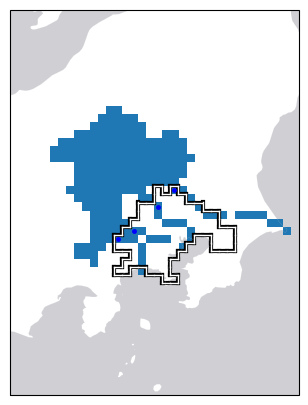

In [11]:
projection = ccrs.PlateCarree(central_longitude=0)
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': projection})
ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#ffffff')
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4')
ax.gridlines(visible=False)

# draw riv_path_array
riv_path_array =  exeption_rivergrid(city_num, riv_nxlonlat_cropped)
tmp = np.ma.masked_where(riv_path_array == 0, riv_path_array)
im = ax.imshow(tmp, extent=(-180,180,-90,90), transform=ccrs.PlateCarree(), cmap='tab20')

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
msk_dir = f'{h08dir}/global_city/dat/vld_cty_'
ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
mask = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
draw_mask_sotowaku((-180,180,-90,90), mask, ax=ax, sotowaku_color='black', linewidth=3)

root_dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
prf_path = f"{root_dir}/dat/cty_prf_/vld_cty_/city_{city_num:08}.gl5"
prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
prf_coords = np.where(prf == 1)
latlon_coords = [grid_to_latlon(row, col, (-180,180,-90,90)) for row, col in zip(prf_coords[0], prf_coords[1])]

for lon, lat in latlon_coords:
    ax.plot(lon, lat, marker='o', color='blue', markersize=2.5, transform=ccrs.PlateCarree())

ax.set_xlim(left, right)
ax.set_ylim(bottom, top)

plt.show()